<a href="https://colab.research.google.com/github/fookseng/LSTM/blob/main/lstm_finalversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is to predict the pixel value at time T, provided data on time (T-2) and time(T-1). And is able to run the following cases:


*   Univariate stateless lstm (feature = pixel) (mode 0)
*   Univariate stateful lstm (feature = pixel) (mode 0)

*   Multivariate stateless lstm
*   Multivariate stateful lstm
> For multivariate LSTM model features, we provide the following combinations.
 - features = pixel + pixels (mode 1)
 - features = pixel + pixels + flow (mode 2)
 - features = pixel + pixels + tide (mode 3)
 - features = pixel + pixels + flow + tide (mode 4)
 - features = pixel + flow (mode 5)
 - features = pixel + tide (mode 6)
 - features = pixel + flow + tide (mode 7)
 
 * pixels are the pixels surrounding the central pixel. 
 -ooo
 -o*o
 -ooo
 -pixels = o, pixel = *

**How to use this code?**
*You only have to make modification in the "Variables initialization" zone.*
1. Select "stateful" or "stateless" by modifying the variable "stateful".
2. Select "TSS" or "CHL" by modifying the variable "tss".
3. Choose the (x, y) coordinate you wish to train model. Modify the variables "x_pos" and "y_pos".
4. Select Univariate or Multivariate by modifying the variable "univariate".
5. Select a mode by modifying the variable "mode".
6. You may modify other variables to meet your own needs. But the above modifications are sufficient to run this code.

**Extra Note:**
*To train multiple models. Simply apply a for loop on the main function. Remember to initialize all the variables for each loop, as colab will save all the variables' value if you do not restart the runtime. Therefore, the previous values will affect the current model. *







In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from google.colab.patches import cv2_imshow # for image display
from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import InputLayer, Dense, Activation, Flatten, LeakyReLU, ReLU, PReLU, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adadelta 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image as im
from keras.preprocessing.image import image
import shutil
import imageio
from numpy import array

In [2]:
# Check tensorflow version
print(tf.__version__)

2.6.0


In [3]:
# Mount Google Drive to access data
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# *Variables initialization*

In [4]:
# The data path for "continuous_for_3_yearly".
path = '/content/gdrive/Shareddrives/namr - water quality forecast/1005data_OutletOnly(8x12)/CHL/continuous_for_3_yearly'
# The path for saving model
savePath = '/content/gdrive/Shareddrives/namr - water quality forecast/fs/result/'

### Define model type
# Stateful or Stateless. If Stateful, set it to "True", else "False"
stateful = False
state_name = 'stateful' if stateful else 'stateless'
# TSS or CHL model? Set the variable 'tss' to True if this is a TSS model, else false.
tss = False
model_name = "tss" if tss else 'chl'
# The coordinate of pixel
x_pos, y_pos = 2, 2
# Univariate or Multivariate model (True=Univariate, False=Multivariate)
univariate = False
model_type = "univariate" if univariate else 'multivariate'
# Mode selection
mode = 4
# model save path
filepath = savePath +'/model_'+ model_type+ '_'+ state_name+ '_'+ str(x_pos)+ '_'+ str(y_pos)+ '_' +model_name+'.h5'

### Model parameters
# number of time steps
n_steps = 2
# Learning Rate
learningRate = 0.001
# Batch size. For stateful LSTM, batch size must be set properly. Change the batch size only if you sure what you are doing.
n_batch = 6
# Number of epoch.
n_epoch = 100
# number of features
if (mode == 0):
  n_features = 1
elif (mode == 1):
  n_features = 9
elif (mode == 2):
  n_features = 10
elif (mode == 3):
  n_features = 10
elif (mode == 4):
  n_features = 11
elif (mode == 5):
  n_features = 2
elif (mode == 6):
  n_features = 2
else:
  n_features = 3

### Define some variables
# Define some variables.
pixel_data_train = []
flow_data_train = []
tide_data_train = []
pixel1_data_train =[]
pixel2_data_train =[]
pixel3_data_train =[]
pixel4_data_train =[]
pixel5_data_train =[]
pixel6_data_train =[]
pixel7_data_train =[]
pixel8_data_train =[]

pixel_data_test = []
flow_data_test = []
tide_data_test = []
pixel1_data_test = []
pixel2_data_test = []
pixel3_data_test = []
pixel4_data_test = []
pixel5_data_test = []
pixel6_data_test = []
pixel7_data_test = []
pixel8_data_test = []

# *Functions*

In [5]:
def create_data(x, y):
  '''
  We will combine dataset from 2011-2017 and 2019 to use as train and valid dataset (8:2).
  2018 dataset will be  used as test set.
  > T2 is time(T-2), T1 is time(T-1), and T is current time T.
  '''
  # Pixel dataset
  images_T2_2019 = np.load(path +'/image_array_0_2019.npy')
  images_T2_2018 = np.load(path +'/image_array_0_2018.npy')
  images_T2_2011_2017 = np.load(path +'/image_array_0_2011_2017.npy')
  images_T1_2019 = np.load(path +'/image_array_1_2019.npy')
  images_T1_2018 = np.load(path +'/image_array_1_2018.npy')
  images_T1_2011_2017 = np.load(path +'/image_array_1_2011_2017.npy')
  images_T_2019 = np.load(path +'/image_array_2_2019.npy')
  images_T_2018 = np.load(path +'/image_array_2_2018.npy')
  images_T_2011_2017 = np.load(path +'/image_array_2_2011_2017.npy')
  # Flow dataset
  flow_T2_2019 = np.load(path +'/flow_array_0_2019.npy')
  flow_T2_2018 = np.load(path +'/flow_array_0_2018.npy')
  flow_T2_2011_2017 = np.load(path +'/flow_array_0_2011_2017.npy')
  flow_T1_2019 = np.load(path +'/flow_array_1_2019.npy')
  flow_T1_2018 = np.load(path +'/flow_array_1_2018.npy')
  flow_T1_2011_2017 = np.load(path +'/flow_array_1_2011_2017.npy')
  flow_T_2019 = np.load(path +'/flow_array_2_2019.npy')
  flow_T_2018 = np.load(path +'/flow_array_2_2018.npy')
  flow_T_2011_2017 = np.load(path +'/flow_array_2_2011_2017.npy')
  # Tide dataset
  tide_T2_2019 = np.load(path +'/delta_tide_array_0_2019.npy')
  tide_T2_2018 = np.load(path +'/delta_tide_array_0_2018.npy')
  tide_T2_2011_2017 = np.load(path +'/delta_tide_array_0_2011_2017.npy')
  tide_T1_2019 = np.load(path +'/delta_tide_array_1_2019.npy')
  tide_T1_2018 = np.load(path +'/delta_tide_array_1_2018.npy')
  tide_T1_2011_2017 = np.load(path +'/delta_tide_array_1_2011_2017.npy')
  tide_T_2019 = np.load(path +'/delta_tide_array_2_2019.npy')
  tide_T_2018 = np.load(path +'/delta_tide_array_2_2018.npy')
  tide_T_2011_2017 = np.load(path +'/delta_tide_array_2_2011_2017.npy')

  print("Creating dataset on point:", x,",", y)
  for i in range(tide_T_2011_2017.size):
      pixel_data_train.append(images_T2_2011_2017[i][x][y])
      pixel_data_train.append(images_T1_2011_2017[i][x][y])
      pixel_data_train.append(images_T_2011_2017[i][x][y])
      flow_data_train.append(flow_T2_2011_2017[i][0])
      flow_data_train.append(flow_T1_2011_2017[i][0])
      flow_data_train.append(flow_T_2011_2017[i][0])
      tide_data_train.append(tide_T2_2011_2017[i][0])
      tide_data_train.append(tide_T1_2011_2017[i][0])
      tide_data_train.append(tide_T_2011_2017[i][0])
  for i in range(tide_T_2019.size):
      pixel_data_train.append(images_T2_2019[i][x][y])
      pixel_data_train.append(images_T1_2019[i][x][y])
      pixel_data_train.append(images_T_2019[i][x][y])
      flow_data_train.append(flow_T2_2019[i][0])
      flow_data_train.append(flow_T1_2019[i][0])
      flow_data_train.append(flow_T_2019[i][0])
      tide_data_train.append(tide_T2_2019[i][0])
      tide_data_train.append(tide_T1_2019[i][0])
      tide_data_train.append(tide_T_2019[i][0])
  for i in range(tide_T_2018.size):
      pixel_data_test.append(images_T2_2018[i][x][y])
      pixel_data_test.append(images_T1_2018[i][x][y])
      pixel_data_test.append(images_T_2018[i][x][y])
      flow_data_test.append(flow_T2_2018[i][0])
      flow_data_test.append(flow_T1_2018[i][0])
      flow_data_test.append(flow_T_2018[i][0])
      tide_data_test.append(tide_T2_2018[i][0])
      tide_data_test.append(tide_T1_2018[i][0])
      tide_data_test.append(tide_T_2018[i][0])
  
  if(mode >= 1 and mode <= 4):
    for i in range(tide_T_2011_2017.size):
      pixel1_data_train.append(images_T2_2011_2017[i][x-1][y+1])
      pixel1_data_train.append(images_T1_2011_2017[i][x-1][y+1])
      pixel1_data_train.append(images_T_2011_2017[i][x-1][y+1])
      pixel2_data_train.append(images_T2_2011_2017[i][x][y+1])
      pixel2_data_train.append(images_T1_2011_2017[i][x][y+1])
      pixel2_data_train.append(images_T_2011_2017[i][x][y+1])
      pixel3_data_train.append(images_T2_2011_2017[i][x+1][y+1])
      pixel3_data_train.append(images_T1_2011_2017[i][x+1][y+1])
      pixel3_data_train.append(images_T_2011_2017[i][x+1][y+1])
      pixel4_data_train.append(images_T2_2011_2017[i][x-1][y])
      pixel4_data_train.append(images_T1_2011_2017[i][x-1][y])
      pixel4_data_train.append(images_T_2011_2017[i][x-1][y])
      pixel5_data_train.append(images_T2_2011_2017[i][x+1][y])
      pixel5_data_train.append(images_T1_2011_2017[i][x+1][y])
      pixel5_data_train.append(images_T_2011_2017[i][x+1][y])
      pixel6_data_train.append(images_T2_2011_2017[i][x-1][y-1])
      pixel6_data_train.append(images_T1_2011_2017[i][x-1][y-1])
      pixel6_data_train.append(images_T_2011_2017[i][x-1][y-1])
      pixel7_data_train.append(images_T2_2011_2017[i][x][y-1])
      pixel7_data_train.append(images_T1_2011_2017[i][x][y-1])
      pixel7_data_train.append(images_T_2011_2017[i][x][y-1])
      pixel8_data_train.append(images_T2_2011_2017[i][x+1][y-1])
      pixel8_data_train.append(images_T1_2011_2017[i][x+1][y-1])
      pixel8_data_train.append(images_T_2011_2017[i][x+1][y-1])
    for i in range(tide_T_2019.size):
      pixel1_data_train.append(images_T2_2019[i][x-1][y+1])
      pixel1_data_train.append(images_T1_2019[i][x-1][y+1])
      pixel1_data_train.append(images_T_2019[i][x-1][y+1])
      pixel2_data_train.append(images_T2_2019[i][x][y+1])
      pixel2_data_train.append(images_T1_2019[i][x][y+1])
      pixel2_data_train.append(images_T_2019[i][x][y+1])
      pixel3_data_train.append(images_T2_2019[i][x+1][y+1])
      pixel3_data_train.append(images_T1_2019[i][x+1][y+1])
      pixel3_data_train.append(images_T_2019[i][x+1][y+1])
      pixel4_data_train.append(images_T2_2019[i][x-1][y])
      pixel4_data_train.append(images_T1_2019[i][x-1][y])
      pixel4_data_train.append(images_T_2019[i][x-1][y])
      pixel5_data_train.append(images_T2_2019[i][x+1][y])
      pixel5_data_train.append(images_T1_2019[i][x+1][y])
      pixel5_data_train.append(images_T_2019[i][x+1][y])
      pixel6_data_train.append(images_T2_2019[i][x-1][y-1])
      pixel6_data_train.append(images_T1_2019[i][x-1][y-1])
      pixel6_data_train.append(images_T_2019[i][x-1][y-1])
      pixel7_data_train.append(images_T2_2019[i][x][y-1])
      pixel7_data_train.append(images_T1_2019[i][x][y-1])
      pixel7_data_train.append(images_T_2019[i][x][y-1])
      pixel8_data_train.append(images_T2_2019[i][x+1][y-1])
      pixel8_data_train.append(images_T1_2019[i][x+1][y-1])
      pixel8_data_train.append(images_T_2019[i][x+1][y-1])
    for i in range(tide_T_2018.size):
      pixel1_data_test.append(images_T2_2018[i][x-1][y+1])
      pixel1_data_test.append(images_T1_2018[i][x-1][y+1])
      pixel1_data_test.append(images_T_2018[i][x-1][y+1])
      pixel2_data_test.append(images_T2_2018[i][x][y+1])
      pixel2_data_test.append(images_T1_2018[i][x][y+1])
      pixel2_data_test.append(images_T_2018[i][x][y+1])
      pixel3_data_test.append(images_T2_2018[i][x+1][y+1])
      pixel3_data_test.append(images_T1_2018[i][x+1][y+1])
      pixel3_data_test.append(images_T_2018[i][x+1][y+1])
      pixel4_data_test.append(images_T2_2018[i][x-1][y])
      pixel4_data_test.append(images_T1_2018[i][x-1][y])
      pixel4_data_test.append(images_T_2018[i][x-1][y])
      pixel5_data_test.append(images_T2_2018[i][x+1][y])
      pixel5_data_test.append(images_T1_2018[i][x+1][y])
      pixel5_data_test.append(images_T_2018[i][x+1][y])
      pixel6_data_test.append(images_T2_2018[i][x-1][y-1])
      pixel6_data_test.append(images_T1_2018[i][x-1][y-1])
      pixel6_data_test.append(images_T_2018[i][x-1][y-1])
      pixel7_data_test.append(images_T2_2018[i][x][y-1])
      pixel7_data_test.append(images_T1_2018[i][x][y-1])
      pixel7_data_test.append(images_T_2018[i][x][y-1])
      pixel8_data_test.append(images_T2_2018[i][x+1][y-1])
      pixel8_data_test.append(images_T1_2018[i][x+1][y-1])
      pixel8_data_test.append(images_T_2018[i][x+1][y-1])
        

  # print(images_T2_2011_2017.size, images_T2_2011_2017.shape)
  # print(images_T2_2019.size, images_T2_2019.shape)
  # print(images_T2_2018.size, images_T2_2018.shape)
  # print(images_T1_2011_2017.size, images_T1_2011_2017.shape)
  # print(images_T1_2019.size, images_T1_2019.shape)
  # print(images_T1_2018.size, images_T1_2018.shape)
  # print(images_T_2011_2017.size, images_T_2011_2017.shape)
  # print(images_T_2019.size, images_T_2019.shape)
  # print(images_T_2018.size, images_T_2018.shape)
  # print(len(pixel_data_train), len(pixel_data_test))
  # print("\n\n")
  # print(tide_T2_2011_2017.size, tide_T2_2011_2017.shape)
  # print(tide_T2_2019.size, tide_T2_2019.shape)
  # print(tide_T2_2018.size, tide_T2_2018.shape)
  # print(tide_T1_2011_2017.size, tide_T1_2011_2017.shape)
  # print(tide_T1_2019.size, tide_T1_2019.shape)
  # print(tide_T1_2018.size, tide_T1_2018.shape)
  # print(tide_T_2011_2017.size, tide_T_2011_2017.shape)
  # print(tide_T_2019.size, tide_T_2019.shape)
  # print(tide_T_2018.size, tide_T_2018.shape)
  # print(len(tide_data_train), len(tide_data_test))
  # print("\n\n")
  return tide_T_2019.size+tide_T_2011_2017.size

In [6]:
# design network
def build_model_stateful(n_features):
    model = Sequential()
    #model.add(LSTM(64, input_shape=(n_steps, n_features), return_sequences= True, batch_input_shape=(n_batch, x_sampled.shape[1], x_sampled.shape[2]), stateful=True))
    model.add(LSTM(64, input_shape=(n_steps, n_features), return_sequences= True, batch_input_shape=(1, x_sampled.shape[1], x_sampled.shape[2]), stateful=True))
    model.add(LSTM(32, input_shape=(n_steps, n_features), return_sequences=False, batch_input_shape=(1, x_sampled.shape[1], x_sampled.shape[2]), stateful=True))
    model.add(Dense(10, activation=ReLU()))
    model.add(Dense(1, activation=ReLU()))
    model.compile(loss='mean_squared_error', optimizer= Nadam(learning_rate=learningRate), metrics=['mean_squared_error'])
    return model
def build_model_stateless(n_features):
    model = Sequential()
    model.add(LSTM(64, input_shape=(n_steps, n_features), return_sequences= True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(10, activation=ReLU()))
    model.add(Dense(1, activation=ReLU()))
    model.compile(loss='mean_squared_error', optimizer= Nadam(learning_rate=learningRate), metrics=['mean_squared_error'])
    return model

In [7]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(0, len(sequence), 3):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
def multi_data_prep(dataset, target):
     X = []
     y = []
     for i in range(0, len(dataset), 3):
         X.append(dataset[i:i+2])
         y.append(target[i+2])
     return np.array(X), np.array(y) 

# *Main function*

Creating dataset on point: 2 , 2
m: 1023
This is a stateless_multivariate LSTM model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 64)             19456     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 10)                330       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 32,213
Trainable params: 32,213
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
137/137 [==============================] - 5s 10ms/step - loss: 0.6887 - mean_squared_error: 0.6887 - val_loss: 0.5016 - val_mean_squared_error: 0.5016
E

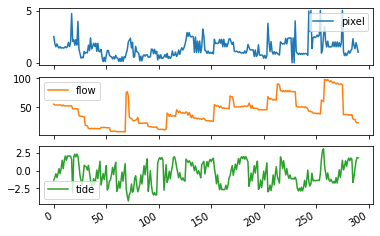

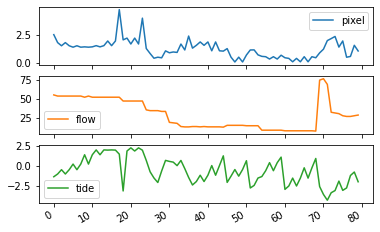

In [8]:
if __name__ == '__main__':
  ### Create data and save as pandas DataFrame
  m = create_data(x_pos, y_pos)
  print("m: " + str(m))
  dic_train = {'pixel': pixel_data_train, 'pixel1': pixel1_data_train, 'pixel2': pixel2_data_train, 'pixel3': pixel3_data_train, 'pixel4': pixel4_data_train, 'pixel5': pixel5_data_train, 'pixel6': pixel6_data_train, 'pixel7': pixel7_data_train, 'pixel8': pixel8_data_train, 'flow': flow_data_train, 'tide': tide_data_train}
  dic_test = {'pixel': pixel_data_test, 'pixel1': pixel1_data_test, 'pixel2': pixel2_data_test, 'pixel3': pixel3_data_test, 'pixel4': pixel4_data_test, 'pixel5': pixel5_data_test, 'pixel6': pixel6_data_test, 'pixel7': pixel7_data_test, 'pixel8': pixel8_data_test, 'flow': flow_data_test, 'tide': tide_data_test}
  df_train = pd.DataFrame(dic_train)
  df_test = pd.DataFrame(dic_test)

  ### Observe statistics and frequency of dataset.
  # df.describe().transpose()
  plot_cols = ['pixel', 'flow', 'tide']
  plot_features = df_test[plot_cols]
  _ = plot_features.plot(subplots=True)
  plot_features = df_test[plot_cols][:80]
  _ = plot_features.plot(subplots=True)

  ### Perform MinMax Scaling
  '''
  # Scale variables (tide and flow)
  features_scaler = MinMaxScaler()
  #features_data = features_scaler.fit_transform(df[["flow", "tide"]])
  features_data = df[["pixel", "flow", "tide"]].to_numpy()
  # Scale target (pixel)
  target_scaler = MinMaxScaler()
  #target_data = target_scaler.fit_transform(df[["pixel"]])
  target_data = df[["pixel"]].to_numpy()
  print("\nNormalized Data")
  print(features_data.shape, features_data.size)
  print(target_data.shape, target_data.size)
  print(features_data[0:10])
  print(target_data[0:10])
  '''
  ### Data Preprocessing.
  if (univariate):
    ### split into samples. These samples will be fed into network for training.
    x_sampled, y_sampled = split_sequence(pixel_data_train, n_steps)
  else:
    if (mode == 1):
      features_data = df_train[["pixel", "pixel1", "pixel2", "pixel3", "pixel4", "pixel5", "pixel6", "pixel7", "pixel8"]].to_numpy()
      features_data_test = df_train[["pixel", "pixel1", "pixel2", "pixel3", "pixel4", "pixel5", "pixel6", "pixel7", "pixel8"]].to_numpy()
    elif (mode == 2):
      features_data = df_train[["pixel", "pixel1", "pixel2", "pixel3", "pixel4", "pixel5", "pixel6", "pixel7", "pixel8", "flow"]].to_numpy()
      features_data_test = df_train[["pixel", "pixel1", "pixel2", "pixel3", "pixel4", "pixel5", "pixel6", "pixel7", "pixel8", "flow"]].to_numpy()
    elif (mode == 3):
      features_data = df_train[["pixel", "pixel1", "pixel2", "pixel3", "pixel4", "pixel5", "pixel6", "pixel7", "pixel8", "tide"]].to_numpy()
      features_data_test = df_train[["pixel", "pixel1", "pixel2", "pixel3", "pixel4", "pixel5", "pixel6", "pixel7", "pixel8", "tide"]].to_numpy()
    elif (mode == 4):
      features_data = df_train[["pixel", "pixel1", "pixel2", "pixel3", "pixel4", "pixel5", "pixel6", "pixel7", "pixel8", "flow", "tide"]].to_numpy()
      features_data_test = df_train[["pixel", "pixel1", "pixel2", "pixel3", "pixel4", "pixel5", "pixel6", "pixel7", "pixel8", "flow", "tide"]].to_numpy()
    elif (mode == 5):
      features_data = df_train[["pixel", "flow"]].to_numpy()
      features_data_test = df_train[["pixel", "flow"]].to_numpy()
    elif (mode == 6):
      features_data = df_train[["pixel", "tide"]].to_numpy()
      features_data_test = df_train[["pixel", "tide"]].to_numpy()
    else:
      features_data = df_train[["pixel", "tide", "flow"]].to_numpy()
      features_data_test = df_train[["pixel", "tide", "flow"]].to_numpy()
    
  target_data = df_train[["pixel"]].to_numpy()
  target_data_test = df_train[["pixel"]].to_numpy()
  x_sampled, y_sampled = multi_data_prep(features_data, target_data)

  ### Reshape the data so that it can fit into the network.
  x_sampled = x_sampled.reshape((x_sampled.shape[0], x_sampled.shape[1], n_features))
  # print("\nx, y size and shape")
  # print(x_sampled.size, x_sampled.shape)
  # print(y_sampled.size, y_sampled.shape)
  # print("\nVisualize the samples.")
  # print(pixel_data_train[0:20])
  # ### summarize the data, sample pair. ([T-2, T-1]	T)
  # for i in range(9):
  #   print(x_sampled[i], y_sampled[i])

  ### Start training the model.
  if (stateful):
    model = build_model_stateful(n_features)
    print("This is a " + state_name +'_' + model_type +" LSTM model")
    model.summary()
    # Train network. Stateful LSTM model has to be train in this for loop manner. 
    for i in range(n_epoch):
      # 保留最低loss
      checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=False, mode='min')
      # 每過100回合loss都沒降的話就把learning rate乘上factor，最多降到0.00001
      rrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1,min_delta=0.0, mode='min', min_lr=0.00001)
      # 若經過400回合，loss都沒有降低的話就提早停止訓練
      es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400, min_delta=0.0)
      callbacks_list = [checkpoint,rrp,es]
      model.fit(x_sampled[0:int(m*0.8)], y_sampled[0:int(m*0.8)], epochs=1, batch_size=1, verbose=1, shuffle=False, callbacks=callbacks_list, validation_data=(x_sampled[int(m*0.8):int(m*1.0)],y_sampled[int(m*0.8):int(m*1.0)]))
      model.reset_states()
  else:
    model = build_model_stateless(n_features)
    print("This is a " + state_name +'_' + model_type +" LSTM model")
    model.summary()
    # Train network. 
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=False, mode='min')
    rrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1,min_delta=0.0, mode='min', min_lr=0.00001)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400, min_delta=0.0)
    callbacks_list = [checkpoint,rrp,es]
    model.fit(x_sampled[0:int(m*0.8)], y_sampled[0:int(m*0.8)], epochs=n_epoch, batch_size=n_batch, verbose=1, shuffle=True, callbacks=callbacks_list, validation_data=(x_sampled[int(m*0.8):int(m*1.0)],y_sampled[int(m*0.8):int(m*1.0)]))

In [9]:
# Demonstrate prediction
model = load_model(filepath)
if (univariate):
    x_test, y_test = split_sequence(pixel_data_test, n_steps)
else:
    x_test, y_test = multi_data_prep(features_data_test, target_data_test)

x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
loss = model.evaluate(x_sampled[0:int(m*0.8)], y_sampled[0:int(m*0.8)], batch_size=1)
print("\nThe model loss on train is: \n")
print(loss[0])
loss = model.evaluate(x_test,y_test, batch_size=1)
print("\nThe model loss on test is: \n")
print(loss[0])
for i in range(x_test.shape[0]):
  testX, testy = x_test[i], y_test[i]
  testX = testX.reshape((1, n_steps, n_features))
  yhat = model.predict(testX, batch_size=1)
  print('>Expected=%.1f, Predicted=%.1f' % (testy, yhat))

818/818 [==============================] - 2s 1ms/step - loss: 0.2910 - mean_squared_error: 0.2910

The model loss on train is: 

0.2910361588001251
1023/1023 [==============================] - 1s 1ms/step - loss: 0.3130 - mean_squared_error: 0.3130

The model loss on test is: 

0.3130154609680176
>Expected=0.6, Predicted=0.6
>Expected=0.2, Predicted=0.6
>Expected=0.7, Predicted=0.3
>Expected=0.8, Predicted=0.8
>Expected=3.8, Predicted=4.4
>Expected=5.0, Predicted=4.8
>Expected=0.7, Predicted=1.1
>Expected=0.7, Predicted=1.1
>Expected=0.7, Predicted=1.0
>Expected=1.4, Predicted=1.3
>Expected=0.8, Predicted=0.9
>Expected=0.7, Predicted=0.5
>Expected=0.5, Predicted=0.6
>Expected=1.0, Predicted=1.0
>Expected=0.8, Predicted=0.7
>Expected=0.2, Predicted=0.7
>Expected=0.4, Predicted=0.4
>Expected=0.5, Predicted=0.5
>Expected=0.6, Predicted=0.6
>Expected=1.5, Predicted=1.0
>Expected=0.9, Predicted=0.7
>Expected=0.4, Predicted=0.6
>Expected=0.8, Predicted=0.7
>Expected=1.5, Predicted=0.7
>Expe